# CITY LIFE. Geospatial analysis

### Task

In this project, you will try to get some valuable insights about customers’
and taxi drivers’ behavior. Maybe it will help a taxi company optimize its
business.
Here are the tasks that you need to do:
1. find out and visualize on a map most popular areas where people ordered a taxi as
well as where they headed to,
2. find out and visualize the most popular routes in different time intervals,
3. find in the dataset locations of the city infrastructure and visualize how the customers were arriving at one of them using an animated map,
4. visualize one day of a taxi driver and how much money he or she earned using an
animated map,
5. visualize one day of the city (working day and weekend day) using an animated
map.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import geopandas as gpd
# import geoplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import folium

from mpl_toolkits.axes_grid1 import make_axes_locatable

from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union

from sklearn.cluster import KMeans, DBSCAN

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull

from datetime import datetime

from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area



### Load data

In [3]:
df_map = gpd.read_file('data/chicago_map.shx')

In [4]:
df_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  77 non-null     geometry
dtypes: geometry(1)
memory usage: 744.0 bytes


In [5]:
rush = pd.read_csv('data/rush_hours_empty.csv',
                   parse_dates=['Trip End Timestamp'],
                   dtype={
                       'name': str,
                       'longitude': float,
                       'latitude': float,
                       'num_of_rides': int,
                         })

In [6]:
rush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                1 non-null      object        
 1   longitude           1 non-null      float64       
 2   latitude            1 non-null      float64       
 3   num_of_rides        1 non-null      int64         
 4   Trip End Timestamp  1 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 168.0+ bytes


In [7]:
taxi_loc = pd.read_csv('data/taxi_locations.csv',
                       parse_dates=['Trip Start Timestamp', 
                                    'Trip End Timestamp'],
                       index_col='Trip ID',
                       dtype={
                           'Pickup Centroid Latitude': float,
                           'Pickup Centroid Longitude': float,
                           'Dropoff Centroid Latitude': float,
                           'Dropoff Centroid Longitude': float,
                           'Taxi ID': str,
                           'Fare': float  
                       }
                      )

In [8]:
taxi_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2506294 entries, 304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea to 21b2d9d623e7a51ad43032bd758a1321e63217e1
Data columns (total 10 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Pickup Centroid Latitude    float64       
 1   Pickup Centroid Longitude   float64       
 2   Pickup Centroid Location    object        
 3   Dropoff Centroid Latitude   float64       
 4   Dropoff Centroid Longitude  float64       
 5   Dropoff Centroid  Location  object        
 6   Trip Start Timestamp        datetime64[ns]
 7   Trip End Timestamp          datetime64[ns]
 8   Taxi ID                     object        
 9   Fare                        float64       
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 210.3+ MB


### Data preparation

Set crs to be able to combine dataframes

In [9]:
df_map.set_crs(epsg=4326, inplace=True)
crs = {'init':'EPSG:4326'}

Create folium map to visualize data in the shapefile (Chicago map)

In [10]:
m = folium.Map(location=[41.85, -87.65], zoom_start=10, tiles='CartoDB positron')

Add df_map data to folium map to visualize polygons (districts) on the real map

In [11]:
for _, r in df_map.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)

In [12]:
m

### Dropoff and Pickup columns to geometry type

In [13]:
taxi_loc['Pickup Centroid Location'] = gpd.GeoSeries.from_wkt(taxi_loc['Pickup Centroid Location'])
taxi_loc['Dropoff Centroid  Location'] = gpd.GeoSeries.from_wkt(taxi_loc['Dropoff Centroid  Location'])

In [14]:
taxi_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2506294 entries, 304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea to 21b2d9d623e7a51ad43032bd758a1321e63217e1
Data columns (total 10 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Pickup Centroid Latitude    float64       
 1   Pickup Centroid Longitude   float64       
 2   Pickup Centroid Location    geometry      
 3   Dropoff Centroid Latitude   float64       
 4   Dropoff Centroid Longitude  float64       
 5   Dropoff Centroid  Location  geometry      
 6   Trip Start Timestamp        datetime64[ns]
 7   Trip End Timestamp          datetime64[ns]
 8   Taxi ID                     object        
 9   Fare                        float64       
dtypes: datetime64[ns](2), float64(5), geometry(2), object(1)
memory usage: 210.3+ MB


### Check for NaN values and duplicates

In [15]:
taxi_loc.isna().sum()

Pickup Centroid Latitude        0
Pickup Centroid Longitude       0
Pickup Centroid Location        0
Dropoff Centroid Latitude       0
Dropoff Centroid Longitude      0
Dropoff Centroid  Location      0
Trip Start Timestamp            0
Trip End Timestamp              0
Taxi ID                         1
Fare                          196
dtype: int64

In [16]:
# points_pick = gpd.GeoDataFrame(taxi_loc, geometry='Pickup Centroid Location', crs=df_map.crs)

In [17]:
# pointInPolys = gpd.tools.sjoin(points_pick, df_map, predicate="within", how='left')

In [18]:
# pointInPolys

## 1. Most popular areas

### 1.1 Clustering analysis

Conduct clustering analysis of pick point and drop off locations based on their coordinates. Clusters might be different for each of the categories (pickpoints and drop-offs).

### Pickpoints

In [19]:
pickups = taxi_loc[['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location']]

In [55]:
pickup_coords = pickups[['Pickup Centroid Longitude', 'Pickup Centroid Latitude']]

We need to define the best number of clusters. In order to do this we can use elbow rule

#### K-means algorythm

##### Elbow curve

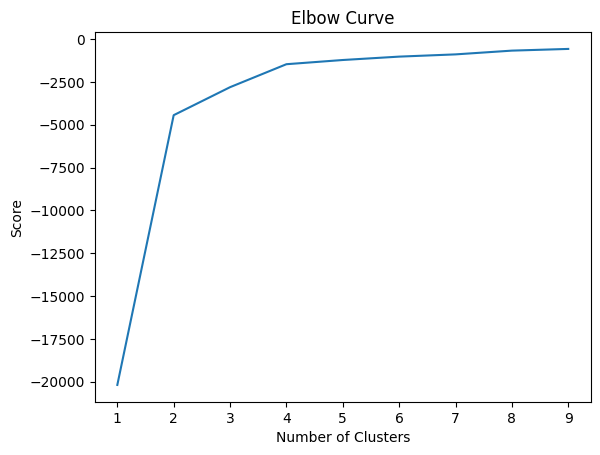

In [21]:
K_clusters = range(1,10)
kmeans = [KMeans(init="k-means++",
                 n_clusters=i,
                 max_iter=300,
                 random_state=42,
                 n_init='auto') for i in K_clusters]
score = [kmeans[i].fit(pickup_coords).score(pickup_coords) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

3? clasters is optimal

Fitting kmeans model for pickpoints

In [22]:
n_clusters = 3

In [23]:
kmeans_pick = KMeans(
    init="k-means++",
    n_clusters=n_clusters,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [24]:
kmeans_pick.fit(pickups[pickups.columns[0:2]]) # Compute k-means clustering.
pickups['pickup_cluster_kmeans'] = kmeans_pick.fit_predict(pickups[pickups.columns[0:2]])
pickups_centers = kmeans_pick.cluster_centers_ # Coordinates of cluster centers.
pickups_labels = kmeans_pick.predict(pickups[pickups.columns[0:2]]) # Labels of each point
pickups.head(5)

/tmp/ipykernel_32742/237264503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pickups['pickup_cluster_kmeans'] = kmeans_pick.fit_predict(pickups[pickups.columns[0:2]])


,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,pickup_cluster_kmeans
Trip ID,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,41.878866,-87.625192,POINT (-87.62519 41.87887),0
b1a8b95ea294663cc3d3cb38a538f464418288c4,41.947792,-87.683835,POINT (-87.68383 41.94779),2
752c8ac4bdf62db4c3d4e810cab915a0ec0ceddc,42.001571,-87.695013,POINT (-87.69501 42.00157),2
6808fa8dc0d009190da2e2416203a7ba012f45a9,41.901567,-87.638404,POINT (-87.63840 41.90157),0
01428cb986d678ea0a8d39b6b35d05d06baa631a,41.892042,-87.631864,POINT (-87.63186 41.89204),0


Creating a geo dataframe from cluster centers points

In [25]:
pickups_centers = pd.DataFrame(pickups_centers, columns=['lat', 'long'])

In [26]:
pickup_centers_coords = pickups_centers[['long', 'lat']].values

In [27]:
pickup_centers_coords

array([[-87.63425905,  41.88192356],
       [-87.90403335,  41.97927151],
       [-87.67165047,  41.95067533]])

In [28]:
geometry = [Point(xy) for xy in zip(pickups_centers['long'], pickups_centers['lat'])]
geo_pickups_centers = gpd.GeoDataFrame(pickups_centers, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [29]:
geo_pickups_centers

,lat,long,geometry
0,41.881924,-87.634259,POINT (-87.63426 41.88192)
1,41.979272,-87.904033,POINT (-87.90403 41.97927)
2,41.950675,-87.671650,POINT (-87.67165 41.95068)


#### Mean-shift algorythm

#### DBSCAN algorythm

In [30]:
# pickup_coords_val = pickup_coords.values #Create a numpy array
# db = DBSCAN().fit(pickup_coords_val) #Cluster the points. eps is max distance to cluster points together
# cluster_labels = pd.Series(db.labels_).rename('pickup_cluster_DBSCAN') #Extract cluster labels
# pickups = pd.concat([pickups, cluster_labels], axis=1) #Add them to the points

# #Adjust eps and plot until it looks as good as possible
# fig, ax = plt.subplots()
# ax.scatter(x=pickups['Pickup Centroid Latitude'], y=pickups['Pickup Centroid Longitude'], c=pickups['pickup_cluster_DBSCAN'], marker='.', cmap='tab10')

# #df.cluster.unique()
# #array([-1,  0,  1,  4,  2,  3,  5,  6,  7,  8]) #points without cluster get -1



# # #Create convex hulls from each cluster
# # hulls = [] #A list to hold clusterids and convex hull geometries
# # for clusterid, frame in df.loc[df['pickup_cluster_DBSCAN']!=-1].groupby('pickup_cluster_DBSCAN'): #For each cluster group except -1
# #     geom = unary_union(frame.geometry.tolist()).convex_hull #Create one multipoint and convex hull it
# #     hulls.append([clusterid, geom])
    
# # df2 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
# # df2 = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=df.crs)

# # df2.to_file(r'/home/bera/Desktop/GIStest/bs_sample_cluster.shp')

In [56]:
pickup_coords_val = pickup_coords.values #Create a numpy array


In [57]:
pickup_coords_val

array([[-87.62519214,  41.87886558],
       [-87.68383494,  41.94779159],
       [-87.69501259,  42.00157103],
       ...,
       [-87.642649  ,  41.87925508],
       [-87.62099291,  41.88498719],
       [-87.75093429,  41.78599852]])

In [ ]:
from collections import defaultdict
from ipywidgets import interactive
import hdbscan
import folium
import re
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = DBSCAN(eps=0.01,min_samples=5).fit(X)
class_predictions= model.labels_
df['CLUSTER_DBSCAN'] = class_predictions

#### Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

#### Agglomerative Hierarchical Clustering

### Drop-offs

In [31]:
dropoffs = taxi_loc[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']]
dropoff_coords = dropoffs[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']]

#### Elbow curve

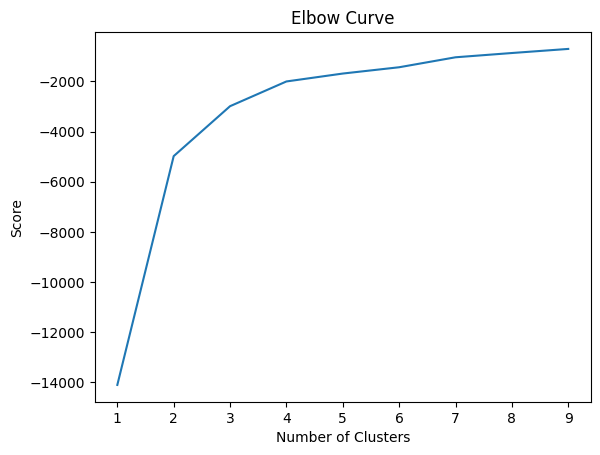

In [32]:
K_clusters = range(1,10)
kmeans = [KMeans(init="k-means++",
                 n_clusters=i,
                 max_iter=300,
                 random_state=42,
                 n_init='auto') for i in K_clusters]
score = [kmeans[i].fit(dropoff_coords).score(dropoff_coords) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

4 clusters is optimal

In [77]:
n_clusters = 7

In [78]:
kmeans_drop = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [79]:
kmeans_drop.fit(dropoffs[dropoffs.columns[0:2]]) # Compute k-means clustering.
dropoffs['dropoff_cluster_kmeans'] = kmeans_drop.fit_predict(dropoffs[dropoffs.columns[0:2]])
dropoffs_centers = kmeans_drop.cluster_centers_ # Coordinates of cluster centers.
dropoffs_labels = kmeans_drop.predict(dropoffs[dropoffs.columns[0:2]]) # Labels of each point
dropoffs.head(5)

/tmp/ipykernel_32742/4257850880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropoffs['dropoff_cluster_kmeans'] = kmeans_drop.fit_predict(dropoffs[dropoffs.columns[0:2]])


,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,dropoff_cluster_kmeans,geometry
Trip ID,,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,41.778877,-87.594925,POINT (-87.59493 41.77888),2,POINT (-87.59493 41.77888)
b1a8b95ea294663cc3d3cb38a538f464418288c4,41.874005,-87.663518,POINT (-87.66352 41.87401),0,POINT (-87.66352 41.87401)
752c8ac4bdf62db4c3d4e810cab915a0ec0ceddc,42.001571,-87.695013,POINT (-87.69501 42.00157),5,POINT (-87.69501 42.00157)
6808fa8dc0d009190da2e2416203a7ba012f45a9,41.901567,-87.638404,POINT (-87.63840 41.90157),3,POINT (-87.63840 41.90157)
01428cb986d678ea0a8d39b6b35d05d06baa631a,41.979071,-87.903040,POINT (-87.90304 41.97907),4,POINT (-87.90304 41.97907)


In [80]:
dropoffs_centers = pd.DataFrame(dropoffs_centers, columns=['lat', 'long'])
dropoff_centers_coords = dropoffs_centers[['long', 'lat']].values

In [81]:
geometry = [Point(xy) for xy in zip(dropoffs_centers['long'], dropoffs_centers['lat'])]
geo_dropoffs_centers = gpd.GeoDataFrame(dropoffs_centers, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [82]:
geo_dropoffs_centers

,lat,long,geometry
0,41.875752,-87.636475,POINT (-87.63647 41.87575)
1,41.939575,-87.663578,POINT (-87.66358 41.93957)
2,41.774753,-87.606193,POINT (-87.60619 41.77475)
3,41.894681,-87.627049,POINT (-87.62705 41.89468)
4,41.979640,-87.902624,POINT (-87.90262 41.97964)
5,41.961051,-87.733585,POINT (-87.73358 41.96105)
6,41.791396,-87.748343,POINT (-87.74834 41.79140)


### 1.2 Cluster borders and centroids

Draw the borders and centroids of the clusters on a map. You will have two maps.

Prepare data and make polygons for pickup clusters (Voronoi diagram)

<!-- ### Pickups -->

In [83]:
geometry = pickups['Pickup Centroid Location']
geo_pickups = gpd.GeoDataFrame(pickups, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [84]:
area = df_map.unary_union

In [85]:
geo_pickups_centers

,lat,long,geometry
0,41.881924,-87.634259,POINT (-87.63426 41.88192)
1,41.979272,-87.904033,POINT (-87.90403 41.97927)
2,41.950675,-87.671650,POINT (-87.67165 41.95068)


In [86]:
pickup_polys, pickup_pts = voronoi_regions_from_coords(pickup_centers_coords, area)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in 

In [87]:
pickup_polys_df = pd.DataFrame.from_dict(pickup_polys, orient='index')
pickup_polys_df = gpd.GeoDataFrame(pickup_polys_df, geometry=0)


Prepare data and make polygons fro dropoff clusters

In [88]:
geometry = dropoffs['Dropoff Centroid  Location']
geo_dropoffs = gpd.GeoDataFrame(dropoffs, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [89]:
dropoff_polys, dropoff_pts = voronoi_regions_from_coords(dropoff_centers_coords, area)
dropoff_polys_df = pd.DataFrame.from_dict(dropoff_polys, orient='index')
dropoff_polys_df = gpd.GeoDataFrame(dropoff_polys_df, geometry=0)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in 

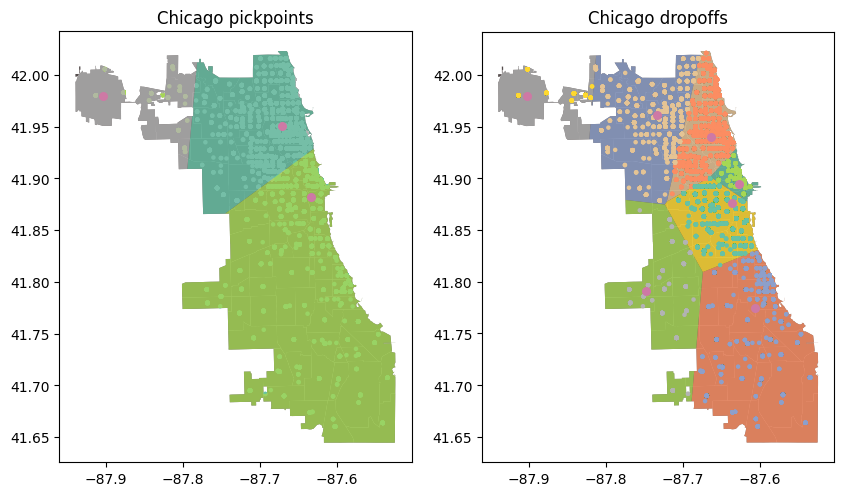

In [90]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = (10,10))
df_map.plot(ax=ax1, color='#554d4d', legend=True, )
geo_pickups.plot(ax=ax1, cmap='Set2', column='pickup_cluster_kmeans', markersize=5)
pickup_polys_df.plot(ax=ax1, cmap='Set2', column=0, alpha=0.8)
ax1.set_title('Chicago pickpoints')
geo_pickups_centers.plot(ax=ax1, color='#ce79a5', markersize=30)

df_map.plot(ax=ax2, color='#554d4d', legend=True, )
dropoff_polys_df.plot(ax=ax2, cmap='Set2', column=0, alpha=0.8)
geo_dropoffs.plot(ax=ax2, cmap='Set2', column='dropoff_cluster_kmeans', markersize=5)
ax2.set_title('Chicago dropoffs')
geo_dropoffs_centers.plot(ax=ax2, color='#ce79a5', markersize=30)


plt.show()

### 3. Largest number of pick points and drop-offs

<!-- ### 7687

Use a color scale to show which clusters (i.e. areas) have the largest number of pick
points and drop-offs.

#### Pickups

In [91]:
pickups_clusters = pickups.groupby('pickup_cluster_kmeans')['Pickup Centroid Location'].count()
pickups_clusters.sort_values(ascending=False)
pickups_clusters_df = pd.DataFrame(pickups_clusters)
pickups_clusters_df = pickups_clusters_df.rename(columns={'Pickup Centroid Location': 'kmeans_cluster_observations'}).reset_index()

In [92]:
pickup_polys_df_ = pickup_polys_df.reset_index().rename(columns={'index': 'pickup_cluster_kmeans'})
pickup_polys_df_ = pickup_polys_df_.merge(pickups_clusters_df, on='pickup_cluster_kmeans')

#### Dropoffs

In [93]:
dropoffs_clusters = dropoffs.groupby('dropoff_cluster_kmeans')['Dropoff Centroid  Location'].count()
dropoffs_clusters.sort_values(ascending=False)
dropoffs_clusters_df = pd.DataFrame(dropoffs_clusters)
dropoffs_clusters_df = dropoffs_clusters_df.rename(columns={'Dropoff Centroid  Location': 'kmeans_cluster_observations'}).reset_index()

In [94]:
dropoff_polys_df_ = dropoff_polys_df.reset_index().rename(columns={'index': 'dropoff_cluster_kmeans'})
dropoff_polys_df_ = dropoff_polys_df_.merge(dropoffs_clusters_df, on='dropoff_cluster_kmeans')

In [95]:
dropoff_polys_df_

,dropoff_cluster_kmeans,0,kmeans_cluster_observations
0,0,"POLYGON ((-87.66450 41.90152, -87.63080 41.928...",834422
1,1,"POLYGON ((-87.68511 41.71364, -87.68495 41.713...",419233
2,2,"MULTIPOLYGON (((-87.77464 41.87960, -87.77464 ...",41919
3,3,"MULTIPOLYGON (((-87.68899 41.68443, -87.68927 ...",963110
4,4,"POLYGON ((-87.66450 41.90152, -87.61628 41.877...",124203
5,5,"POLYGON ((-87.67738 42.01943, -87.67735 42.019...",84393
6,6,"POLYGON ((-87.82206 41.93783, -87.82237 41.937...",39014


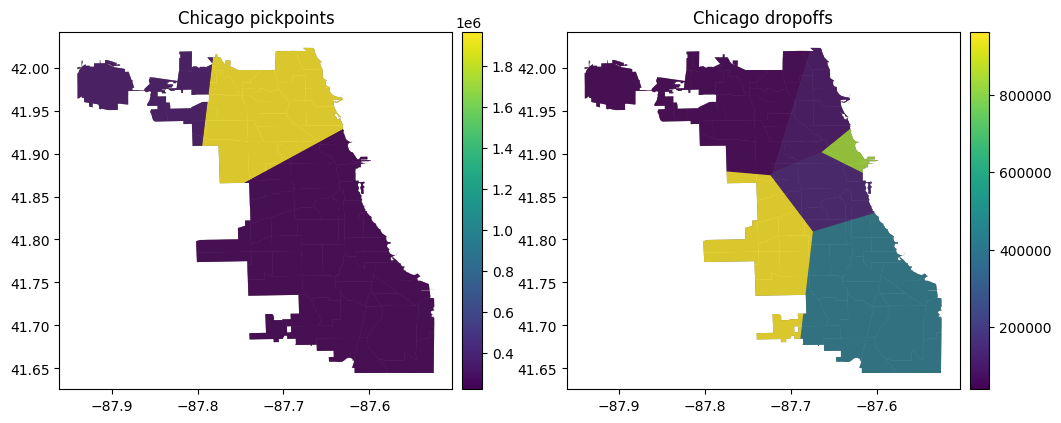

In [96]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,10))
df_map.plot(ax=ax1, color='#554d4d')
# geo_pickups.plot(ax=ax1, cmap='Set2', column='pickup_cluster_kmeans', markersize=5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
pickup_polys_df_.plot(ax=ax1, cax=cax, cmap='viridis', column='kmeans_cluster_observations', alpha=0.8, legend=True)
ax1.set_title('Chicago pickpoints')
# geo_pickups_centers.plot(ax=ax1, color='#e2c1d2', markersize=30)

df_map.plot(ax=ax2, color='#554d4d')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
dropoff_polys_df_.plot(ax=ax2, cax=cax, cmap='viridis', column='kmeans_cluster_observations', alpha=0.8, legend=True)
# geo_dropoffs.plot(ax=ax2, cmap='Set2', column='dropoff_cluster_kmeans', markersize=5)
ax2.set_title('Chicago dropoffs')
# geo_dropoffs_centers.plot(ax=ax2, color='#e2c1d2', markersize=30)


plt.show()

## 2. Most popular routes

### 2.1 Clustering analysis

Conduct a clustering analysis of taxi rides based on the coordinates of the pick
point location and drop off.

In [137]:
routes = taxi_loc[['Dropoff Centroid Longitude', 'Pickup Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid Latitude']]
routes_val = routes.values

In [138]:
routes

,Dropoff Centroid Longitude,Pickup Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Latitude
Trip ID,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,-87.594925,41.878866,-87.594925,41.778877
b1a8b95ea294663cc3d3cb38a538f464418288c4,-87.663518,41.947792,-87.663518,41.874005
752c8ac4bdf62db4c3d4e810cab915a0ec0ceddc,-87.695013,42.001571,-87.695013,42.001571
6808fa8dc0d009190da2e2416203a7ba012f45a9,-87.638404,41.901567,-87.638404,41.901567
01428cb986d678ea0a8d39b6b35d05d06baa631a,-87.903040,41.892042,-87.903040,41.979071
...,...,...,...,...
21bc604a66e2c479f767bdfd6ddfec6a7b57065b,-87.632746,41.979071,-87.632746,41.880994
21beff87d222ce3c0e1c62f9278c1ed8a455550a,-87.649489,41.922686,-87.649489,41.922686
21baf5e9060fb66f7b5e11444d32d07275a3a2ee,-87.632746,41.879255,-87.632746,41.880994


In [139]:
n_clusters = 10

In [140]:
kmeans_routes = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [141]:
kmeans_routes.fit(routes_val) # Compute k-means clustering.
routes['routes_cluster_kmeans'] = kmeans_routes.fit_predict(routes_val)
routes_centers = kmeans_routes.cluster_centers_ # Coordinates of cluster centers.
routes_labels = kmeans_routes.predict(routes_val) # Labels of each point
routes.head(5)

/tmp/ipykernel_32742/2691231120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes['routes_cluster_kmeans'] = kmeans_routes.fit_predict(routes_val)


,Dropoff Centroid Longitude,Pickup Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Latitude,routes_cluster_kmeans
Trip ID,,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,-87.594925,41.878866,-87.594925,41.778877,5
b1a8b95ea294663cc3d3cb38a538f464418288c4,-87.663518,41.947792,-87.663518,41.874005,9
752c8ac4bdf62db4c3d4e810cab915a0ec0ceddc,-87.695013,42.001571,-87.695013,42.001571,2
6808fa8dc0d009190da2e2416203a7ba012f45a9,-87.638404,41.901567,-87.638404,41.901567,8
01428cb986d678ea0a8d39b6b35d05d06baa631a,-87.903040,41.892042,-87.903040,41.979071,7


In [142]:
routes_centers_df = pd.DataFrame(routes_centers, columns=['Dropoff Centroid Longitude', 'Pickup Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid Latitude'])

In [144]:
routes_centers_df

,Dropoff Centroid Longitude,Pickup Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Latitude
0,-87.665295,41.893265,-87.665295,41.931613
1,-87.744107,41.946178,-87.744107,41.955170
2,-87.666104,41.965934,-87.666104,41.955762
3,-87.746972,41.872131,-87.746972,41.790541
4,-87.650864,41.885060,-87.650864,41.880963
5,-87.617716,41.879801,-87.617716,41.840186
6,-87.628855,41.779918,-87.628855,41.860490
7,-87.902653,41.915916,-87.902653,41.979642
8,-87.627589,41.887536,-87.627589,41.889851
9,-87.629847,41.971682,-87.629847,41.886485


In [145]:
geometry = [Point(xy) for xy in zip(routes_centers_df['Dropoff Centroid Longitude'], routes_centers_df['Pickup Centroid Latitude'])]
# geo_dropoffs_centers = gpd.GeoDataFrame(dropoffs_centers, 
#                           crs = crs, 
#                           geometry = geometry)

TypeError: ufunc 'points' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 2.2 Centroids

Draw centroids of the top 5 popular clusters (routes).

In [ ]:
fig, ax = plt.subplots(figsize = (12,10))
df_map.plot(ax=ax1, color='#554d4d')
# geo_pickups.plot(ax=ax1, cmap='Set2', column='pickup_cluster_kmeans', markersize=5)
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="5%", pad=0.1)
pickup_polys_df_.plot(ax=ax1, cax=cax, cmap='viridis', column='kmeans_cluster_observations', alpha=0.8, legend=True)
ax1.set_title('Chicago pickpoints')
# geo_pickups_centers.plot(ax=ax1, color='#e2c1d2', markersize=30)

df_map.plot(ax=ax2, color='#554d4d')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
dropoff_polys_df_.plot(ax=ax2, cax=cax, cmap='viridis', column='kmeans_cluster_observations', alpha=0.8, legend=True)
# geo_dropoffs.plot(ax=ax2, cmap='Set2', column='dropoff_cluster_kmeans', markersize=5)
ax2.set_title('Chicago dropoffs')
# geo_dropoffs_centers.plot(ax=ax2, color='#e2c1d2', markersize=30)


plt.show()

3. Draw routes between centroids of a cluster – not a direct line from point A to point
B, but a path that takes into account the city streets.

## 3. City infrastructure

1. Find locations of the city infrastructure (airports, stadiums, parks, universities)
using the data and make up your own algorithm of how to find them. Find at least
6 of that kind of location.

2. Find the rush hour for each of the locations – timestamp when the location had the
largest number of dropoffs and save the information into that file : "rush_hours_empty.csv"
(in attachment).

3. Visualize one day of any of the locations including that rush hour showing how
people from different places were coming to the location and then were leaving it
on an animated map.

4. When the ride finishes, it should disappear on the map. In other words, it should
look like firing neurons in the brain.

5. The map should display time.

## 4. One day of a taxi driver

1. For the taxi driver with ID (2ea4ad2950f3bbdfdcfa7adb48e0dcee49d8a714b7024342f0302
eeb9e891dfd55a6f35bb7bc7af06398fb4f55583e1659cb11b432848296bfd2b7d3084e7de1)
visualize his or her rides during the day (2019-05-31). Display the current amount
of money earned.

2. When the ride finishes, it should NOT disappear on the animated map

3. Every time the ride finishes the counter of money should be updated.

4. The map should display time.

## 5. One day of the city

1. Visualize all the rides in the city during the day (2019-05-16) on an animated map.

2. When the ride finishes, it should disappear on the map. In other words, it should
look like firing neurons in the brain.

3. The map should display time

## Bonus

## Links

- https://www.kaggle.com/code/jrw2200/nyc-taxi-trips-clustering/notebook
- https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1
- https://gis.stackexchange.com/questions/439823/draw-polygons-around-a-set-of-points-and-create-clusters-in-python
- https://www.youtube.com/watch?v=7m0Bq1EGPPg
- https://github.com/Coding-with-Adam/Dash-by-Plotly/tree/master/Good_to_Know/Dash2.0/Jupyter
- https://medium.com/analytics-vidhya/clustering-taxi-geolocation-data-to-predict-location-of-taxi-service-stations-pt-1-2471303e0965
- https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html
- https://medium.com/codex/clustering-geographic-data-on-an-interactive-map-in-python-60a5d13d6452
- https://medium.com/thelorry-product-tech-data/the-clustering-algorithm-with-geolocation-data-d6dd07ed36a

- https://www.youtube.com/watch?v=V9dk3EqaK3k&list=PLh3I780jNsiTnCs2LNt4ckbV-c2HatCFg&index=10
- https://docs.google.com/document/d/1X7TJUt3UI1ZBgvVqGMahUJ3REgrSZ92bHJgX6nIdABM/edit

- https://plotly.com/python/maps/

- https://medium.com/analytics-vidhya/clustering-taxi-geolocation-data-to-predict-location-of-taxi-service-stations-pt-1-2471303e0965

- https://colab.research.google.com/github/yennanliu/yennj12_blog_V2/blob/master/_notebooks/2020-04-03-nyc-taxi-eda.ipynb

- https://towardsdatascience.com/clustering-in-geospatial-applications-which-model-should-you-use-59a039332c45

- https://hal.science/hal-02947181/document